In [1]:
import boto3
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import precision_recall_cutoff as prc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import precision_recall_cutoff


### defining bucket###
s3=boto3.resource('s3')
bucket_name= 'dmw-448'
bucket = s3.Bucket(bucket_name)

### definging CSV ###
file_key = 'train.csv'
bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')


# Reading the csv file and seperating columkns
train = pd.read_csv(file_content_stream, sep = '|')
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [2]:
# Defining the file to be read from s3 bucket
file_key = "test.csv"

bucket_object1 = bucket.Object(file_key)
file_object1 = bucket_object1.get()
file_content_stream = file_object1.get('Body')

# Reading the csv file
test = pd.read_csv(file_content_stream, sep = '|')
test.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526


In [3]:
#creating variables from last homework
## reconstructed HWK 4 because I was missing parts to the assignment
train['interaction_1'] = np.where((train['trustLevel'] <= 1.5) & (train['scannedLineItemsPerSecond'] <= 0.012), 1, 0)
train['interaction_2'] = np.where((train['trustLevel'] <= 1.5) & (train['scannedLineItemsPerSecond'] > 0.012) & (train['totalScanTimeInSeconds'] <= 895.0), 1, 0)
train['interaction_3'] = np.where((train['trustLevel'] <= 1.5) & (train['scannedLineItemsPerSecond'] > 0.012) & (train['totalScanTimeInSeconds'] > 895.0), 1, 0)
train['interaction_4'] = np.where((train['trustLevel'] > 1.5) & (train['trustLevel'] <= 2.5) & (train['totalScanTimeInSeconds'] <= 1298.0), 1, 0)
train['interaction_5'] = np.where((train['trustLevel'] > 1.5) & (train['trustLevel'] <= 2.5) & (train['totalScanTimeInSeconds'] > 1298.0), 1, 0)
train['interaction_6'] = np.where((train['trustLevel'] > 1.5) & (train['trustLevel'] > 2.5), 1, 0)


test['interaction_1'] = np.where((test['trustLevel'] <= 1.5) & (test['scannedLineItemsPerSecond'] <= 0.012), 1, 0)
test['interaction_2'] = np.where((test['trustLevel'] <= 1.5) & (test['scannedLineItemsPerSecond'] > 0.012) & (test['totalScanTimeInSeconds'] <= 895.0), 1, 0)
test['interaction_3'] = np.where((test['trustLevel'] <= 1.5) & (test['scannedLineItemsPerSecond'] > 0.012) & (test['totalScanTimeInSeconds'] > 895.0), 1, 0)
test['interaction_4'] = np.where((test['trustLevel'] > 1.5) & (test['trustLevel'] <= 2.5) & (test['totalScanTimeInSeconds'] <= 1298.0), 1, 0)
test['interaction_5'] = np.where((test['trustLevel'] > 1.5) & (test['trustLevel'] <= 2.5) & (test['totalScanTimeInSeconds'] > 1298.0), 1, 0)
test['interaction_6'] = np.where((test['trustLevel'] > 1.5) & (test['trustLevel'] > 2.5), 1, 0)

In [4]:
# Defining variables
X = train.drop(columns = ['fraud'])
Y = train['fraud']

#Identifying top features
results = list()

for i in tqdm(range(0, 100)):
   #Splitting the data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    #Building the random forest model
    RF = RandomForestClassifier(max_depth = 3, n_estimators = 500).fit(X_train, Y_train)
    
    #Extracting feature importances
    results.append(RF.feature_importances_)

#Changing to data frame
results = pd.DataFrame(results)
results.columns = X.columns


#computing averages and sorting importances
results = pd.DataFrame(results.apply(np.mean, axis = 0))
results = pd.DataFrame({'Feature': results.index, 'Importance': results[0].values})
results = results.sort_values(by = 'Importance', ascending = False)
results


100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


,Feature,Importance
11,interaction_3,0.341314
0,trustLevel,0.178638
14,interaction_6,0.105606
6,scannedLineItemsPerSecond,0.081153
8,lineItemVoidsPerPosition,0.057952
1,totalScanTimeInSeconds,0.052679
10,interaction_2,0.039523
7,valuePerSecond,0.031978
2,grandTotal,0.024472
3,lineItemVoids,0.021222


In [5]:
## Engineering three features by using the strong heredity principle
train['feature_1'] = train['interaction_3'] * train['trustLevel']
train['feature_2'] = train['interaction_3'] * train['interaction_6']
train['feature_3'] = train['interaction_6'] * train['trustLevel']

In [6]:
test['feature_1'] = test['interaction_3'] * test['trustLevel']
test['feature_2'] = test['interaction_3'] * test['interaction_6']
test['feature_3'] = test['interaction_6'] * test['trustLevel']

[Text(697.5, 475.65000000000003, 'interaction_3 <= 0.5\ngini = 0.104\nsamples = 1503\nvalue = [1420, 83]'),
 Text(348.75, 339.75, 'interaction_2 <= 0.5\ngini = 0.046\nsamples = 1432\nvalue = [1398, 34]'),
 Text(174.375, 203.85000000000002, 'interaction_5 <= 0.5\ngini = 0.019\nsamples = 1328\nvalue = [1315, 13]'),
 Text(87.1875, 67.94999999999999, 'gini = 0.003\nsamples = 1244\nvalue = [1242, 2]'),
 Text(261.5625, 67.94999999999999, 'gini = 0.228\nsamples = 84\nvalue = [73, 11]'),
 Text(523.125, 203.85000000000002, 'totalScanTimeInSeconds <= 410.5\ngini = 0.322\nsamples = 104\nvalue = [83, 21]'),
 Text(435.9375, 67.94999999999999, 'gini = 0.077\nsamples = 50\nvalue = [48, 2]'),
 Text(610.3125, 67.94999999999999, 'gini = 0.456\nsamples = 54\nvalue = [35, 19]'),
 Text(1046.25, 339.75, 'scannedLineItemsPerSecond <= 0.015\ngini = 0.428\nsamples = 71\nvalue = [22, 49]'),
 Text(871.875, 203.85000000000002, 'totalScanTimeInSeconds <= 1475.0\ngini = 0.473\nsamples = 26\nvalue = [16, 10]'),
 Tex

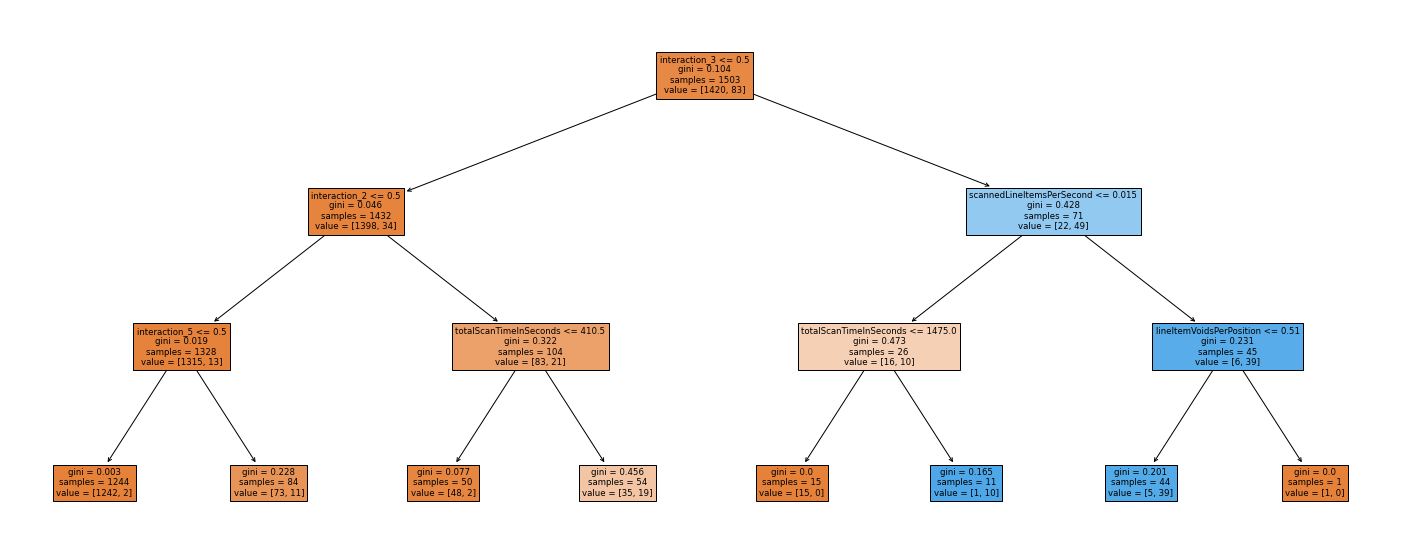

In [13]:
# Defining variables
X = train.drop(columns = ['fraud'])
Y = train['fraud']

#Building model for decision tree
md1 = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

#Visualizing model
fig = plt.figure(figsize = (25, 10))
plot_tree(md1, feature_names = X_train.columns, filled = True)

In [15]:
train['Interaction_new_1'] = np.where((train['interaction_3'] <= 0.5) & (train['interaction_2'] <= 0.5) & (train['interaction_5'] <= 0.5), 1, 0)
train['Interaction_new_2'] = np.where((train['interaction_3'] <= 0.5) & (train['interaction_2'] <= 0.5) & (train['totalScanTimeInSeconds'] <= 410.5), 1, 0)
train['Interaction_new_3'] = np.where((train['interaction_3'] >= 0.5) & (train['scannedLineItemsPerSecond'] <= 0.015) & (train['totalScanTimeInSeconds'] <= 1475), 1, 0)


In [16]:

# Defining variables
X = train.drop(columns = ['fraud'])
Y = train['fraud']

#Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

In [18]:
#buiding model with all variables
#Building random forest model  
RF = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

#Predicting test
RF_pred = RF.predict_proba(X_test)[:, 1]

#Predicting labels
RF_labels =prc.precision_recall_cutoff(Y_test, RF_pred)

#Printing classification report
print(classification_report(Y_test, RF_labels))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       355
           1       0.63      0.81      0.71        21

    accuracy                           0.96       376
   macro avg       0.81      0.89      0.84       376
weighted avg       0.97      0.96      0.96       376



In [20]:
## removing interactions
X_train = X_train.drop(columns = ['feature_1', 'feature_2', 'feature_3', 'interaction_1', 'interaction_2', 'interaction_3','Interaction_new_1','Interaction_new_2','Interaction_new_3'], axis = 1)
X_test = X_test.drop(columns = ['feature_1', 'feature_2', 'feature_3', 'interaction_1', 'interaction_2', 'interaction_3','Interaction_new_1','Interaction_new_2', 'Interaction_new_3'], axis = 1)

## Random forest 
RF = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

## Predicting on test
RF_pred = RF.predict_proba(X_test)[:, 1]

## Predicting the labels
RF_labels = precision_recall_cutoff.precision_recall_cutoff(Y_test, RF_pred)

## Computing the classification report
print(classification_report(Y_test, RF_labels))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       355
           1       0.70      0.76      0.73        21

    accuracy                           0.97       376
   macro avg       0.84      0.87      0.86       376
weighted avg       0.97      0.97      0.97       376



## Based on these results I would use Random forest without 